## Homework 2: Canny edge detector

**Due date:** October 15th 2019

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

**Load and visualize image**

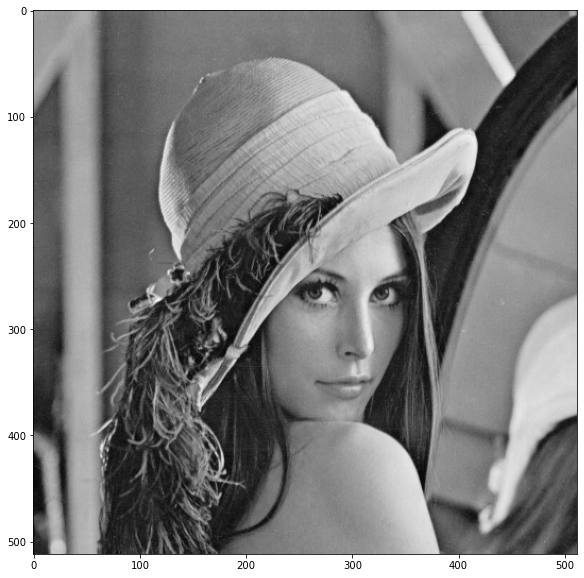

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

name = 'lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

**Detailed instructions:**

a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

In [2]:
def gaussian_filter(img, sigma, threshold=0.05):
    g_x = ndimage.gaussian_filter(img, sigma=(sigma, sigma), order=(0, 1))
    g_y = ndimage.gaussian_filter(img, sigma=(sigma, sigma), order=(1, 0))
    g_norm = np.sqrt(np.square(g_x) + np.square(g_y))
    g_theta = np.arctan2(g_y, g_x)
    mask = g_norm >= threshold*img.max()
    g_norm = g_norm * mask
    return g_norm, g_theta

In [3]:
g_norm, g_theta = gaussian_filter(img, sigma=1.4, threshold=0.05)

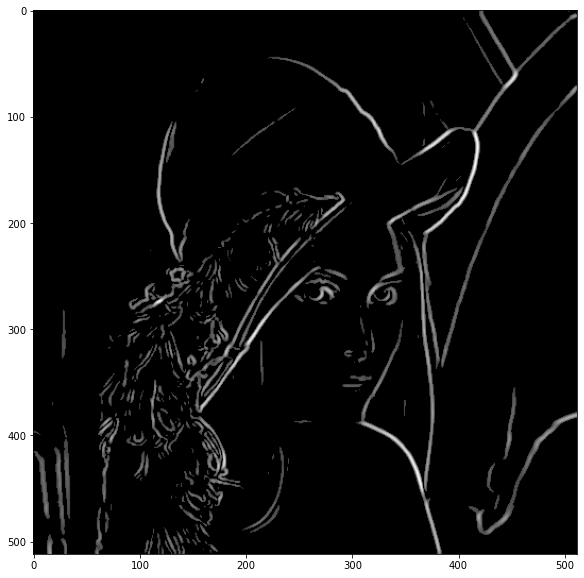

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(g_norm)

In [5]:
g_theta

array([[ 0.55843225,  0.18475202, -2.98115969, ..., -3.13571606,
        -3.1406151 , -3.13697973],
       [ 1.34604779,  2.80841239, -2.80684281, ..., -3.07392617,
        -3.0921486 , -3.03624138],
       [ 1.90239494, -3.12572017, -2.76057234, ..., -2.80931028,
        -2.8490129 , -2.56261161],
       ...,
       [-1.15052311, -0.48685854, -0.07053054, ...,  1.20262635,
         1.48612127,  1.56132177],
       [-0.5561763 , -0.04674117,  0.1957824 , ...,  0.86471825,
         1.209337  ,  1.46360117],
       [-0.08788851,  0.02716377,  0.10258619, ...,  0.30336168,
         0.55183734,  1.11721184]])

## **Discussion:**
### $\sigma:$ width of the Gaussian filter; large $\sigma$ detects large-scale edges and small $\sigma$ detects fine edges.

### $T:$ threshold for the norm of the gradient so that all edge elements are kept while most of the noise is suppressed.

b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary image with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [6]:
def nms(g_norm, g_theta):
    output = np.zeros(g_norm.shape, dtype=np.int32)
    M, N = g_norm.shape
    angle = g_theta * 180. / np.pi # convert into degrees
    angle[angle < 0.] += 180. # we regard both along and against the direction of the gradient
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                theta = angle[i, j]
                curr = g_norm[i, j]
                
                if (0 <= theta < 22.5) or (157.5 <= theta <= 180.):
                    a, b = g_norm[i, j-1], g_norm[i, j+1]
                elif 22.5 <= theta < 67.5:
                    a, b = g_norm[i+1, j-1], g_norm[i-1, j+1]
                elif 67.5 <= theta < 112.5:
                    a, b = g_norm[i+1, j], g_norm[i-1, j]
                elif 112.5 <= theta < 157.5:
                    a, b = g_norm[i-1, j-1], g_norm[i+1, j+1] 
                
                if (curr >= a) and (curr >= b):
                    output[i, j] = 1.
                
            except IndexError: # out of bounds
                pass
            
    return output
    

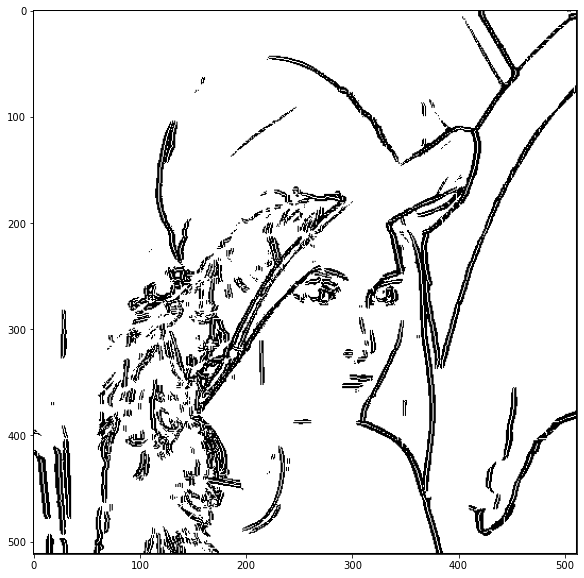

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(nms(g_norm, g_theta))

c- Combine step 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step 'c' with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [8]:
def hysteresis_thresholding(img, sigma=1.4, low=0.02, high=0.05):
    M, N = img.shape
    t2, t2_theta = gaussian_filter(img, sigma=sigma, threshold=high)
    t1, t1_theta = gaussian_filter(img, sigma=sigma, threshold=low)
    t1 = nms(t1, t1_theta)
    t2 = nms(t2, t2_theta)
    output = t2.copy()
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                if t1[i, j] == 1: # if weak
                    if (t2[i+1, j-1] == 1) or (t2[i, j-1] == 1) or (t2[i-1, j-1] == 1) \
                    or (t2[i+1, j] == 1) or (t2[i-1, j] == 1) or (t2[i+1, j+1] == 1) \
                    or (t2[i, j+1] == 1) or (t2[i-1, j+1] == 1): # if any of the 8 neighbors is strong
                        output[i, j] = 1
            except IndexError:
                pass
            
    return output

In [9]:
def display(img, edges):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(edges)
    fig.tight_layout()

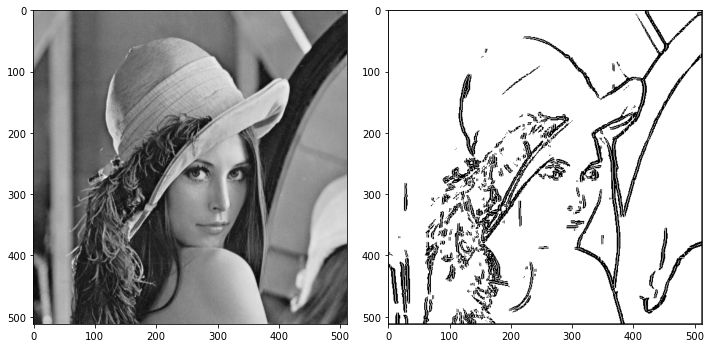

In [10]:
display(img, hysteresis_thresholding(img, sigma=1.4, low=0.01, high=0.05))

e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

In [47]:
def load_image(name):
    img = plt.imread(name)
    img = rgb2gray(img)
    
    return img

## Experimenting with $\sigma$ value

### fixing the weak and strong threshold to be respectively $0.01$ and $0.05$ and tuning $\sigma$, we can see that as we increase the value of $\sigma$, the model will gradually only pick up large-scale edges and discard the fine edges. For example, for the below image, as we increase $\sigma$, the model starts to discard the edges on the brick wall in the background and also some fine facial edges.

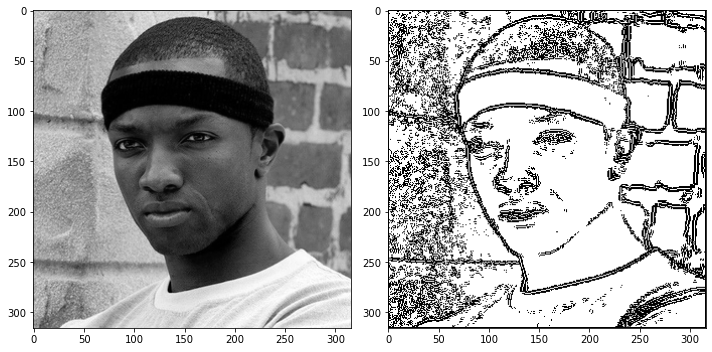

In [79]:
marlo = load_image("marlo.jpg")
display(marlo, hysteresis_thresholding(marlo, sigma=0.5, low=0.01, high=0.05))

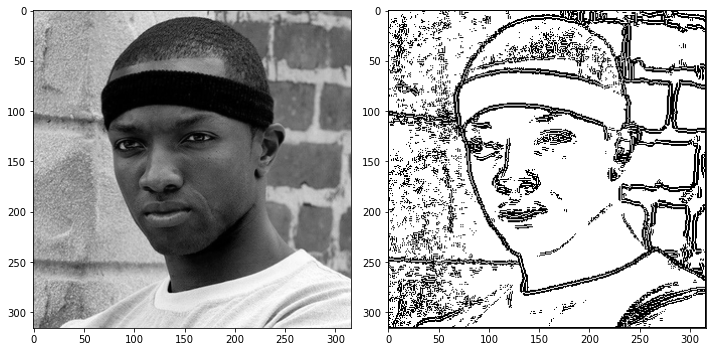

In [75]:
display(marlo, hysteresis_thresholding(marlo, sigma=0.75, low=0.01, high=0.05))

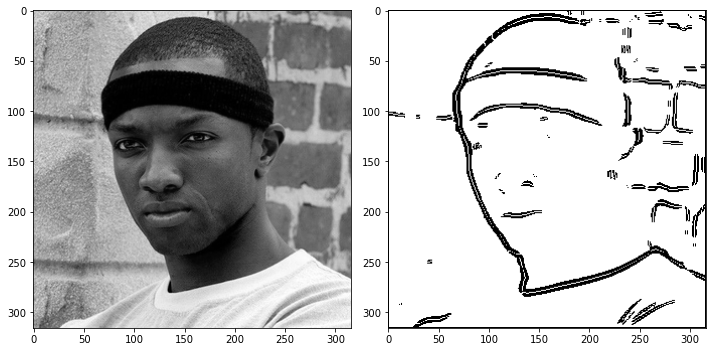

In [80]:
display(marlo, hysteresis_thresholding(marlo, sigma=2, low=0.01, high=0.05))

In [81]:
andrew = load_image("andrew.jpg")

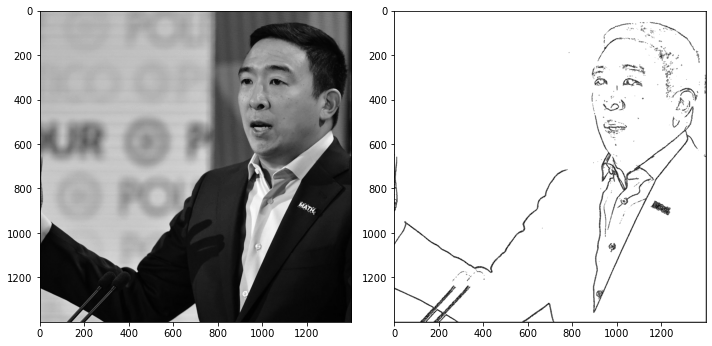

In [87]:
display(andrew, hysteresis_thresholding(andrew, sigma=0.5, low=0.01, high=0.05))

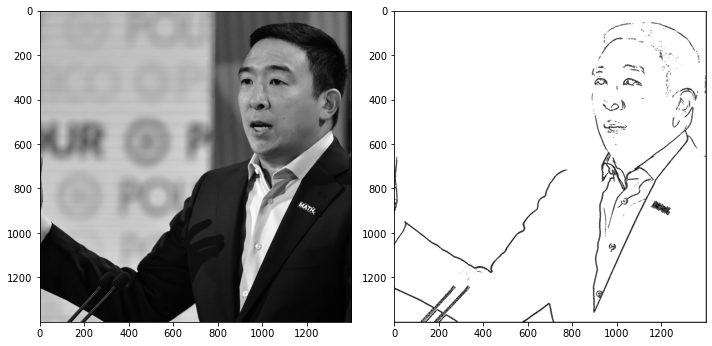

In [88]:
display(andrew, hysteresis_thresholding(andrew, sigma=1, low=0.01, high=0.05))

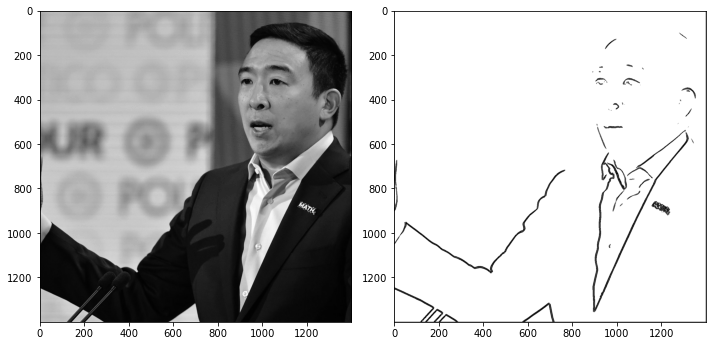

In [90]:
display(andrew, hysteresis_thresholding(andrew, sigma=2.5, low=0.01, high=0.05))

## Experimenting with the threshold value

### Tuning the weak and strong threshold value and fixing $\sigma=1.4$, we can see that as we increase the value of the strong threshold, the model starts to discard the fine edges and focuses only on the large-scale edges. On the other hand, as we decrease the value of the weak threshold, the model will catch more fine edges since it is theoretically more possible that any of the weak pixels now is connected to a strong pixel.

### However, this is not guranteed, as shown in the last image where tuning the low threshold value seems to have no effect on the result. This is due to low connectivity between the weak and strong pixels. Thus, to get the best empirical result, because the connectivity is unknown beforehand, it is better to not start with a high strong threshold so that we will be able to initialize with an ample amount of strong pixels and then pick up the remaining connected weak pixels by tuning the low threshold value.

In [94]:
saul = load_image("saul.jpg")

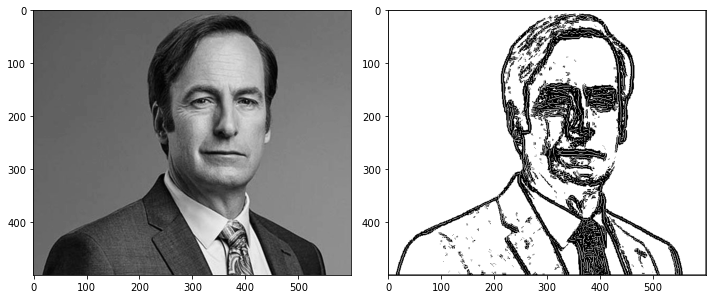

In [108]:
display(saul, hysteresis_thresholding(saul, sigma=1.4, low=0.01, high=0.02))

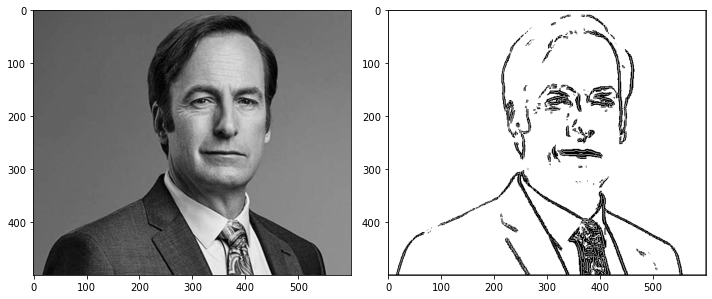

In [109]:
display(saul, hysteresis_thresholding(saul, sigma=1.4, low=0.01, high=0.05))

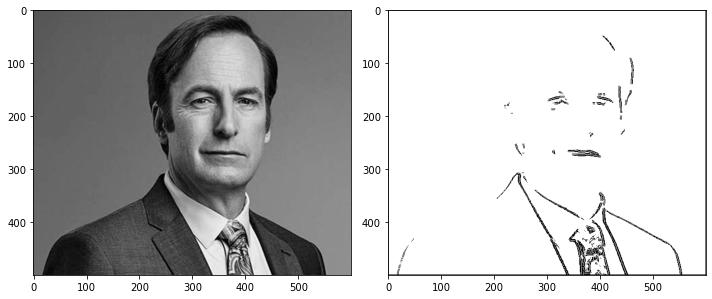

In [110]:
display(saul, hysteresis_thresholding(saul, sigma=1.4, low=0.01, high=0.1))

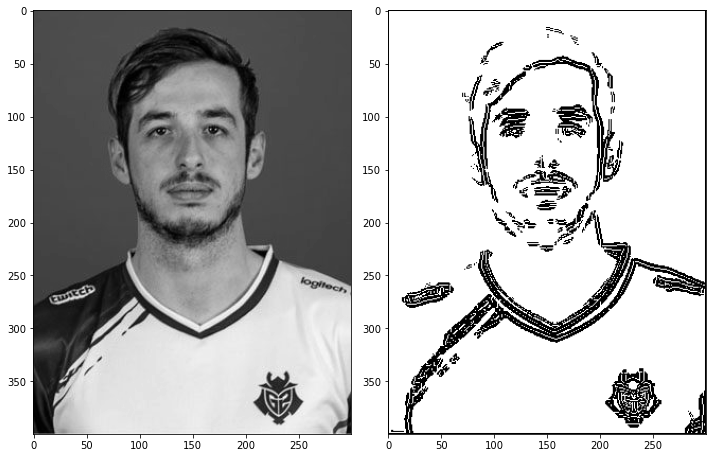

In [111]:
kennys = load_image("kennys.jpeg")
display(kennys, hysteresis_thresholding(kennys, sigma=1.4, low=0.03, high=0.05))

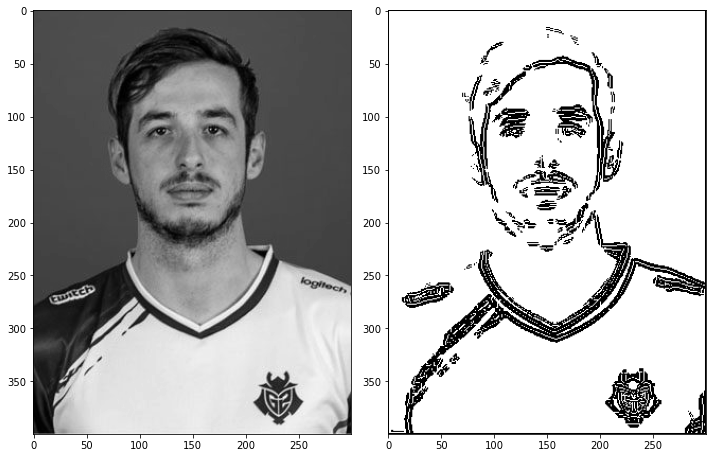

In [112]:
display(kennys, hysteresis_thresholding(kennys, sigma=1.4, low=0.015, high=0.05))

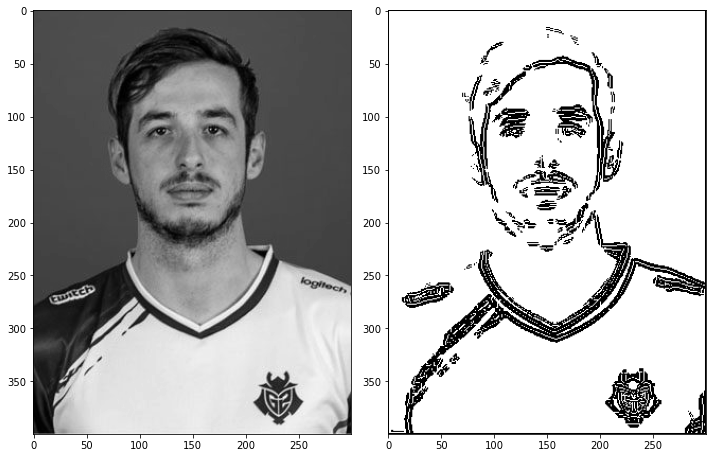

In [113]:
display(kennys, hysteresis_thresholding(kennys, sigma=1.4, low=0.01, high=0.05))